
Прогнозирование с помощью случайного леса 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn import metrics

Было принято решение прогнозировать столбец rose

In [ ]:
df = pd.read_csv('wine_Austral2.dat', sep="\t")
df

,fort,dry,sweet,red,rose,spark,total,year_,month_,date_
0,2585,1954,85,464,112,1686,15136,1980,1,JAN 1980
1,3368,2302,89,675,118,1591,16733,1980,2,FEB 1980
2,3210,3054,109,703,129,2304,20016,1980,3,MAR 1980
3,3111,2414,95,887,99,1712,17708,1980,4,APR 1980
4,3756,2226,91,1139,116,1471,18019,1980,5,MAY 1980
...,...,...,...,...,...,...,...,...,...,...
169,1568,3685,280,1728,35,1968,22784,1994,2,FEB 1994
170,1965,3754,187,2201,42,1720,23565,1994,3,MAR 1994
171,2659,3708,279,2455,48,1725,26323,1994,4,APR 1994
172,2354,3210,193,2204,44,1674,23779,1994,5,MAY 1994


Построим график и проверим, какой тип тренда (линейный или нет) и какой тип сезонности ( аддитивный или мультипликативный), наблюдается. На первом графике виден линейный тренд и мультипликативная сезонность. Проверим вид сезонности, добавим график логарифма от этой же величины. После логирафмирования сезонные отклонения стали одинаковыми, это подтверждает  мультипликативный характер сезонных отклонений.

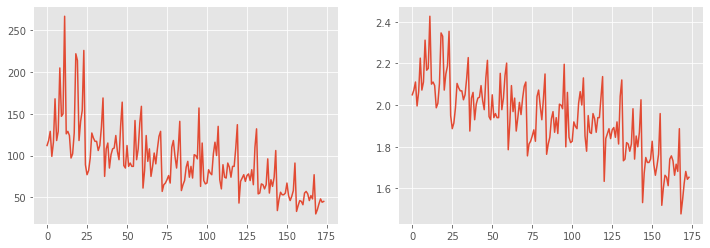

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['rose'].plot(ax=ax1)
ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['rose'])).plot(ax=ax2)


Создадим первый предиктор модели month_num -- порядковый номер пары (месяц, год). <br>
Прологарифмируем временной ряд. <br>
На случай ошибки с трендом добавляем квадраты месяца

In [ ]:
df1 = pd.DataFrame()
df1['month_num'] = range(1, len(df) + 1)
df1['logx'] =  np.log10(df['rose'])
df1['month_num_2'] = df1['month_num']**2
df1

,month_num,logx,month_num_2
0,1,2.049218,1
1,2,2.071882,4
2,3,2.110590,9
3,4,1.995635,16
4,5,2.064458,25
...,...,...,...
169,170,1.544068,28900
170,171,1.623249,29241
171,172,1.681241,29584
172,173,1.643453,29929


Количество лет (кратность индикаторов без учета прогноза)

In [ ]:
174/12

14.5

Создадим новые переменные - индикаторы месяцев

In [ ]:
df1["m01"] = ([1,0,0,0,0,0,0,0,0,0,0,0]*16)[0:len(df)]
df1["m02"] = ([0,1,0,0,0,0,0,0,0,0,0,0]*16)[0:len(df)]
df1["m03"] = ([0,0,1,0,0,0,0,0,0,0,0,0]*16)[0:len(df)]
df1["m04"] = ([0,0,0,1,0,0,0,0,0,0,0,0]*16)[0:len(df)]
df1["m05"] = ([0,0,0,0,1,0,0,0,0,0,0,0]*16)[0:len(df)]
df1["m06"] = ([0,0,0,0,0,1,0,0,0,0,0,0]*16)[0:len(df)]
df1["m07"] = ([0,0,0,0,0,0,1,0,0,0,0,0]*16)[0:len(df)]
df1["m08"] = ([0,0,0,0,0,0,0,1,0,0,0,0]*16)[0:len(df)]
df1["m09"] = ([0,0,0,0,0,0,0,0,1,0,0,0]*16)[0:len(df)]
df1["m10"] = ([0,0,0,0,0,0,0,0,0,1,0,0]*16)[0:len(df)]
df1["m11"] = ([0,0,0,0,0,0,0,0,0,0,1,0]*16)[0:len(df)]
df1["m12"] = ([0,0,0,0,0,0,0,0,0,0,0,1]*16)[0:len(df)]


In [ ]:
#  Создаем матрицу предикторов.
X1 = df1.drop(columns=["logx"])
X = X1.values

In [ ]:
#  Создаем матрицу (столбец) откликов.
y = df1['logx']

Тренд не растущий, можно не предсказывать по разности ряда. Предсказываем по логарифму.

Подберем наилучший параметр n_estimators с помощью кросс-валидации. Оценивать будем по r2 метрике.

In [ ]:
n_estimators = np.arange(500, 1000, 100)
cv = model_selection.KFold(n_splits=3)
r2 = np.full((n_folds, len(n_estimators)), -9999.0)
fold_num = 0
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    j_count = 0

    for j in n_estimators:
        
        model = RandomForestRegressor(n_estimators=j, random_state= 123)
        model.fit(X_train, y_train)
        model.score(X_test, y_test)

        y_pred = model.predict(X_test)

        r2[fold_num, j_count ]= metrics.r2_score(y_test, y_pred)

        j_count = j_count +1
    fold_num = fold_num +1
r2

array([[0.81580897, 0.81784718, 0.81676998, 0.81727565, 0.81704202],
       [0.71043288, 0.7098071 , 0.71135049, 0.71359884, 0.71460752],
       [0.73247448, 0.73386522, 0.73416865, 0.73464683, 0.73512348],
       [0.72334711, 0.72889588, 0.72990638, 0.72957007, 0.72885381],
       [0.83841378, 0.83647401, 0.83536847, 0.83567842, 0.8347746 ]])

Как можно видеть самый оптимальный вариант последний - n_estimators = 900, т.к. чем R2 ближе к 1, тем удачнее регрессионная модель (оцениваем по среднему значению метрик).

Натренируем модель при данном параметре

In [ ]:
model = RandomForestRegressor(n_estimators=900, random_state=123)
model.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=900, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

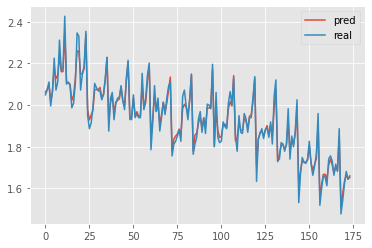

In [ ]:
#  Сравним подгонку и ряд логарифмов
pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()

In [ ]:
#  критерий качества
print("SSE = ", sum((y - model.predict(X))**2))

SSE =  0.1440507126503191


Cумма квадратов регрессионных остатков достаточно маленькая. Можно использовать модель для дальнейшего прогноза.

In [ ]:
#  Прогноз на 8 месяцев
horizon = 8
#  Готовим маторицу предикторов для вычисления прогнозов
df_3= pd.DataFrame()

df_3['month_num'] = range((len(df)+1), (len(df)+horizon+1))
df_3['month_num_2'] = df_3['month_num']**2

In [ ]:
#  Добавляем индикаторы месяцев. 
#  Первый месяц должен быть 7, т.к. продолжаем ряд 
df_3["m07"] = ([1,0,0,0,0,0,0,0,0,0,0,0])[0:horizon]
df_3["m08"] = ([0,1,0,0,0,0,0,0,0,0,0,0])[0:horizon]
df_3["m09"] = ([0,0,1,0,0,0,0,0,0,0,0,0])[0:horizon]
df_3["m10"] = ([0,0,0,1,0,0,0,0,0,0,0,0])[0:horizon]
df_3["m11"] = ([0,0,0,0,1,0,0,0,0,0,0,0])[0:horizon]
df_3["m12"] = ([0,0,0,0,0,1,0,0,0,0,0,0])[0:horizon]
df_3["m01"] = ([0,0,0,0,0,0,1,0,0,0,0,0])[0:horizon]
df_3["m02"] = ([0,0,0,0,0,0,0,1,0,0,0,0])[0:horizon]
df_3["m03"] = ([0,0,0,0,0,0,0,0,1,0,0,0])[0:horizon]
df_3["m04"] = ([0,0,0,0,0,0,0,0,0,1,0,0])[0:horizon]
df_3["m05"] = ([0,0,0,0,0,0,0,0,0,0,1,0])[0:horizon]
df_3["m06"] = ([0,0,0,0,0,0,0,0,0,0,0,1])[0:horizon]


In [ ]:
df_3

,month_num,month_num_2,m07,m08,m09,m10,m11,m12,m01,m02,m03,m04,m05,m06
0,175,30625,1,0,0,0,0,0,0,0,0,0,0,0
1,176,30976,0,1,0,0,0,0,0,0,0,0,0,0
2,177,31329,0,0,1,0,0,0,0,0,0,0,0,0
3,178,31684,0,0,0,1,0,0,0,0,0,0,0,0
4,179,32041,0,0,0,0,1,0,0,0,0,0,0,0
5,180,32400,0,0,0,0,0,1,0,0,0,0,0,0
6,181,32761,0,0,0,0,0,0,1,0,0,0,0,0
7,182,33124,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
#  Прогноз для логарфмов
res = model.predict(df_3)

res

array([1.52165443, 1.59112326, 1.64113208, 1.66226585, 1.64468694,
       1.65962116, 1.69095332, 1.66946323])

In [ ]:
#  Прогноз для исходного ряда
10**model.predict(df_3)

array([33.23949567, 39.00526777, 43.76551893, 45.94791964, 44.12522588,
       45.66896388, 49.08551182, 46.71574017])

In [ ]:
#  матрица с подгонкой
pred['forecast'] = np.nan
pred.head()

,pred,real,forecast
0,2.062631,2.049218,NaN
1,2.074960,2.071882,NaN
2,2.098928,2.110590,NaN
3,2.017952,1.995635,NaN
4,2.065533,2.064458,NaN


In [ ]:
#  матрица с прогнозом
df_4 = pd.DataFrame(res, columns=['forecast'])
df_4['real'] = np.nan
df_4['pred'] = np.nan
df_4.head()

,forecast,real,pred
0,1.521654,NaN,NaN
1,1.591123,NaN,NaN
2,1.641132,NaN,NaN
3,1.662266,NaN,NaN
4,1.644687,NaN,NaN


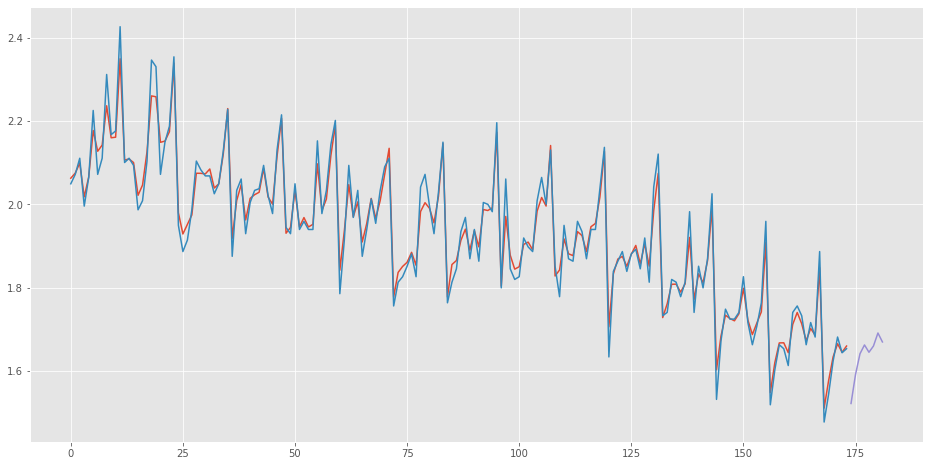

In [ ]:
#  объединяем матрицы, задаем новые индексы
pred_1 = pd.concat(
    [pred, df_4],
    sort=False
).reset_index(drop=True)

plt.figure(figsize=(16,8))
plt.plot(pred_1)
plt.show()

In [ ]:
#  Возвращаемся к исходному ряду
pred_11 = 10**pred_1

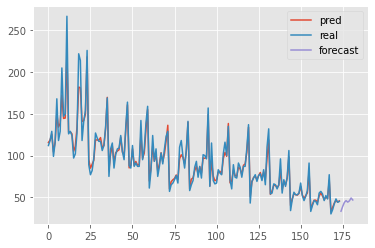

In [ ]:
pred_11.plot()